In [93]:
import hopsworks
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib  # For model saving
# Ensure you have the right imports for your specific model

project = hopsworks.login()
fs = project.get_feature_store()




Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/549021
Connected. Call `.close()` to terminate connection gracefully.


In [94]:
try: 
    feature_view = fs.get_feature_view(name="el_three", version=1)
except:
    fg = fs.get_feature_group(name="el_three_v3", version=2)
    query = fg.select_all()
    feature_view = fs.create_feature_view(name="el_three",
                                      version=1,
                                      description="sensor 3 with electric charger",
                                      labels=["package_type"],
                                      query=query)

In [95]:
# create a training dataset as dataframe
feature, label = feature_view.training_data(
    description = 'el3 training dataset',
)

feature = feature[['x','y','z']]

Finished: Reading data from Hopsworks, using ArrowFlight (1.55s) 


In [96]:
label.values

array([['PackageType.HEART_BEAT'],
       ['PackageType.HEART_BEAT'],
       ['PackageType.HEART_BEAT'],
       ...,
       ['PackageType.HEART_BEAT'],
       ['PackageType.HEART_BEAT'],
       ['PackageType.HEART_BEAT']], dtype=object)

In [99]:
# Assuming you use a scikit-learn model or similar
from sklearn.ensemble import RandomForestClassifier


X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train.values.ravel())

# Evaluate the model
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")


Model Accuracy: 0.9552609776304888


In [100]:
y_pred = model.predict(X_test)
y_pred

array(['PackageType.HEART_BEAT', 'PackageType.HEART_BEAT',
       'PackageType.HEART_BEAT', ..., 'PackageType.HEART_BEAT',
       'PackageType.HEART_BEAT', 'PackageType.HEART_BEAT'], dtype=object)

In [101]:

from sklearn.metrics import classification_report

metrics = classification_report(y_test, y_pred, output_dict=True)
print(metrics)

{'PackageType.CHANGE': {'precision': 0.75, 'recall': 0.5121951219512195, 'f1-score': 0.6086956521739131, 'support': 82.0}, 'PackageType.HEART_BEAT': {'precision': 0.9652476107732406, 'recall': 0.9875555555555555, 'f1-score': 0.976274165202109, 'support': 1125.0}, 'accuracy': 0.9552609776304888, 'macro avg': {'precision': 0.8576238053866203, 'recall': 0.7498753387533875, 'f1-score': 0.792484908688011, 'support': 1207.0}, 'weighted avg': {'precision': 0.9506243265284968, 'recall': 0.9552609776304888, 'f1-score': 0.9513019712764155, 'support': 1207.0}}


In [102]:
print(classification_report(y_test, y_pred, output_dict=False))


                        precision    recall  f1-score   support

    PackageType.CHANGE       0.75      0.51      0.61        82
PackageType.HEART_BEAT       0.97      0.99      0.98      1125

              accuracy                           0.96      1207
             macro avg       0.86      0.75      0.79      1207
          weighted avg       0.95      0.96      0.95      1207



In [103]:
from sklearn.metrics import confusion_matrix

results = confusion_matrix(y_test, y_pred)
print(results)

[[  42   40]
 [  14 1111]]


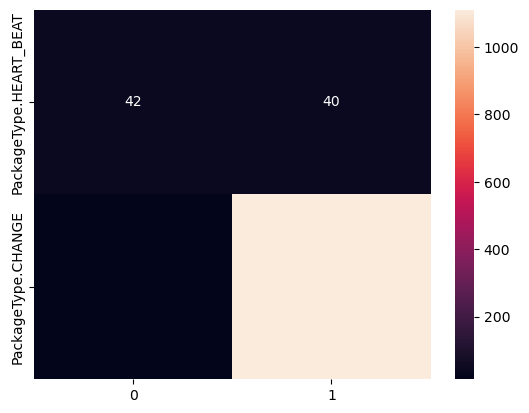

In [104]:
from matplotlib import pyplot
import seaborn as sns

df_cm = pd.DataFrame(results, ['PackageType.HEART_BEAT', 'PackageType.CHANGE'])

cm = sns.heatmap(df_cm, annot=True)

fig = cm.get_figure()
fig.savefig("/Users/magdalenabaran/semester_project_2/confusion_matrix.png") 
fig.show()

In [92]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import os
import joblib
import hopsworks
import shutil

project =  hopsworks.login()
mr = project.get_model_registry()

# The 'iris_model' directory will be saved to the model registry
model_dir="el3_random_forrest_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
joblib.dump(model, model_dir + "/el3_random_forrest_model.pkl")
shutil.copyfile("/Users/magdalenabaran/semester_project_2/confusion_matrix.png", model_dir + "/confusion_matrix.png")

input_example = X_train.sample()
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

iris_model = mr.python.create_model(
    version=1,
    name="el3_random_forrest_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    input_example=input_example, 
    description="Package_type prediction")

iris_model.save(model_dir)

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/549021
Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/17004 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/4298793 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/17 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/373 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/549021/models/el3_random_forrest_model/1


Model(name: 'el3_random_forrest_model', version: 1)